Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Label: 0


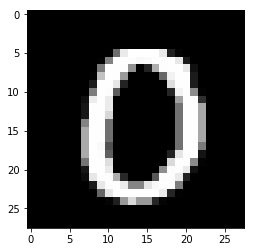

In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data')

i = 10
img = mnist.train.images[i]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: {}".format(mnist.train.labels[i]))

In [2]:
def get_inputs(noise_dim, image_height, image_width, image_depth):
    """
    @param noise_dim: 噪声图片的size
    @param image_height: 真实图像的height
    @param image_width: 真实图像的width
    @param image_depth: 真实图像的depth
    """ 
    inputs_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_depth], name='inputs_real')
    inputs_noise = tf.placeholder(tf.float32, [None, noise_dim], name='inputs_noise')
    
    return inputs_real, inputs_noise

def build_generator(noise_img, output_dim, is_train=True, alpha=0.01):
    
    with tf.variable_scope("generator", reuse=(not is_train)):
        
        # 100 x 1   -->   4 x 4 x 512  by FC layer
        layer1 = tf.layers.dense(noise_img, 4*4*512)
        layer1 = tf.reshape(layer1, [-1,4,4,512])
        # BN
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        # L-ReLU
        layer1 = tf.maximum(alpha*layer1, layer1)
        # dropout
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 4 x 4 x 512   ->   7 x 7 x 256
        """
        before_conv: mi x mi x di
        filter: f x f
        strides: s
        padding: p, p = valid => p = 0; p = same => p = (f - 1)/2
        after_conv: mo x mo x do
        
        mo = ceil((mi + 2p - f)/s + 1)
        
        4 = ceil((7 - f)/1 + 1)
        f = 4
        """
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 4, strides=1, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 7 x 7 x 256   ->   14 x 14 x 128
        """
        7 = ceil((14 - 1)/s + 1)
        s = 2
        """
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha*layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 14 x 14 x 128   ->   28 x 28 x 1
        logits = tf.layers.conv2d_transpose(layer3, output_dim, 3, strides=2, padding='same')
        
        # remember resize output range(-1,1) to mnist range(0,1)
        outputs = tf.tanh(logits)
        
        return outputs

In [3]:
def build_discriminator(input_img, reuse=False, alpha=0.01):
    with tf.variable_scope("discriminator", reuse=reuse):
        # 28 x 28 x 1 to 14 x 14 x 128
        # 第一层不加入BN
        layer1 = tf.layers.conv2d(input_img, 128, 3, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        # 14 x 14 x 128 to 7 x 7 x 256
        layer2 = tf.layers.conv2d(layer1, 256, 3, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        # 7 x 7 x 256 to 4 x 4 x 512
        layer3 = tf.layers.conv2d(layer2, 512, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        # 4 x 4 x 512 to 4*4*512 x 1
        flatten = tf.reshape(layer3, (-1, 4*4*512))
        logits = tf.layers.dense(flatten, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

In [4]:
def get_loss(inputs_real, inputs_noise, image_depth, smooth=0.1):
    """
    @param inputs_real: 输入图片，tensor类型
    @param inputs_noise: 噪声图片，tensor类型
    @param image_depth: 图片的depth（或者叫channel）
    @param smooth: label smoothing的参数
    """
    
    g_outputs = build_generator(inputs_noise, image_depth, is_train=True)
    d_logits_real, d_outputs_real = build_discriminator(inputs_real)
    d_logits_fake, d_outputs_fake = build_discriminator(g_outputs, reuse=True)
    
    # 计算Loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_outputs_fake)*(1-smooth)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_outputs_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_outputs_fake)))
    d_loss = tf.add(d_loss_real, d_loss_fake)
    
    return g_loss, d_loss

In [5]:
def get_optimizer(g_loss, d_loss, beta1=0.4, learning_rate=0.001):
    """
    @param g_loss: Generator的Loss
    @param d_loss: Discriminator的Loss
    @learning_rate: 学习率
    """
    
    train_vars = tf.trainable_variables()
    
    g_vars = [var for var in train_vars if var.name.startswith("generator")]
    d_vars = [var for var in train_vars if var.name.startswith("discriminator")]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return g_opt, d_opt

In [6]:
def plot_images(samples):
    fig, axes = plt.subplots(nrows=1, ncols=25, sharex=True, sharey=True, figsize=(50,2))
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [7]:
def show_generator_output(sess, n_images, inputs_noise, output_dim):
    """
    @param sess: TensorFlow session
    @param n_images: 展示图片的数量
    @param inputs_noise: 噪声图片
    @param output_dim: 图片的depth（或者叫channel）
    @param image_mode: 图像模式：RGB或者灰度
    """
    cmap = 'Greys_r'
    noise_shape = inputs_noise.get_shape().as_list()[-1]
    # 生成噪声图片
    examples_noise = np.random.uniform(-1, 1, size=[n_images, noise_shape])

    samples = sess.run(build_generator(inputs_noise, output_dim, False),
                       feed_dict={inputs_noise: examples_noise})

    
    result = np.squeeze(samples, -1)
    return result

In [8]:
# 定义参数
batch_size = 64
noise_size = 100
epochs = 5
n_samples = 25
learning_rate = 0.001
beta1 = 0.4
# 为GPU动态分配空间，否则默认空间太小，会卡死
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def train(noise_size, data_shape, batch_size, n_samples):
    """
    @param noise_size: 噪声size
    @param data_shape: 真实图像shape
    @batch_size:
    @n_samples: 显示示例图片数量
    """
    
    # 存储loss
    losses = []
    steps = 0
    
    inputs_real, inputs_noise = get_inputs(noise_size, data_shape[1], data_shape[2], data_shape[3])
    g_loss, d_loss = get_loss(inputs_real, inputs_noise, data_shape[-1])
    g_train_opt, d_train_opt = get_optimizer(g_loss, d_loss, beta1, learning_rate)

    # 一定注意为GPU动态分配空间
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        # 迭代epoch
        for e in range(epochs):
            for batch_i in range(mnist.train.num_examples//batch_size):
                steps += 1
                batch = mnist.train.next_batch(batch_size)

                batch_images = batch[0].reshape((batch_size, data_shape[1], data_shape[2], data_shape[3]))
                # scale to -1, 1
                batch_images = batch_images * 2 - 1

                # noise
                batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))

                # run optimizer
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_noise: batch_noise})
                
                if steps % 101 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    train_loss_g = g_loss.eval({inputs_real: batch_images,
                                                inputs_noise: batch_noise})
                    losses.append((train_loss_d, train_loss_g))
                    # 显示图片
                    samples = show_generator_output(sess, n_samples, inputs_noise, data_shape[-1])
                    plot_images(samples)
                    print("Epoch {}/{}....".format(e+1, epochs), 
                          "Discriminator Loss: {:.4f}....".format(train_loss_d),
                          "Generator Loss: {:.4f}....". format(train_loss_g))

Epoch 1/5.... Discriminator Loss: 0.5410.... Generator Loss: 3.7789....
Epoch 1/5.... Discriminator Loss: 0.7797.... Generator Loss: 1.4634....
Epoch 1/5.... Discriminator Loss: 0.9798.... Generator Loss: 1.9772....
Epoch 1/5.... Discriminator Loss: 1.2690.... Generator Loss: 2.2226....
Epoch 1/5.... Discriminator Loss: 0.9716.... Generator Loss: 1.5078....
Epoch 1/5.... Discriminator Loss: 0.9547.... Generator Loss: 1.1752....
Epoch 1/5.... Discriminator Loss: 1.4499.... Generator Loss: 2.7617....
Epoch 1/5.... Discriminator Loss: 0.9094.... Generator Loss: 1.1312....
Epoch 2/5.... Discriminator Loss: 0.8037.... Generator Loss: 1.9903....
Epoch 2/5.... Discriminator Loss: 0.8295.... Generator Loss: 1.4331....
Epoch 2/5.... Discriminator Loss: 0.7019.... Generator Loss: 2.0403....
Epoch 2/5.... Discriminator Loss: 1.1476.... Generator Loss: 2.5103....
Epoch 2/5.... Discriminator Loss: 0.8975.... Generator Loss: 1.9850....
Epoch 2/5.... Discriminator Loss: 0.8050.... Generator Loss: 1.6

E:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 3/5.... Discriminator Loss: 0.8351.... Generator Loss: 2.4459....
Epoch 3/5.... Discriminator Loss: 0.8099.... Generator Loss: 1.3926....
Epoch 3/5.... Discriminator Loss: 0.6721.... Generator Loss: 2.1214....
Epoch 3/5.... Discriminator Loss: 1.0741.... Generator Loss: 0.8528....
Epoch 3/5.... Discriminator Loss: 0.7687.... Generator Loss: 1.4998....
Epoch 4/5.... Discriminator Loss: 0.7056.... Generator Loss: 1.9824....
Epoch 4/5.... Discriminator Loss: 0.5569.... Generator Loss: 2.6095....
Epoch 4/5.... Discriminator Loss: 0.6909.... Generator Loss: 2.4300....
Epoch 4/5.... Discriminator Loss: 0.6980.... Generator Loss: 1.6713....
Epoch 4/5.... Discriminator Loss: 1.0824.... Generator Loss: 4.2706....
Epoch 4/5.... Discriminator Loss: 0.7257.... Generator Loss: 1.4192....
Epoch 4/5.... Discriminator Loss: 0.6911.... Generator Loss: 1.9228....
Epoch 4/5.... Discriminator Loss: 0.6569.... Generator Loss: 3.1783....
Epoch 4/5.... Discriminator Loss: 1.2469.... Generator Loss: 0.9

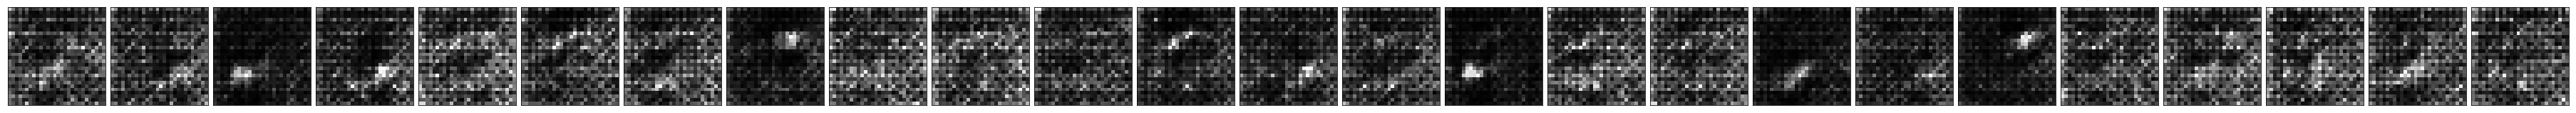

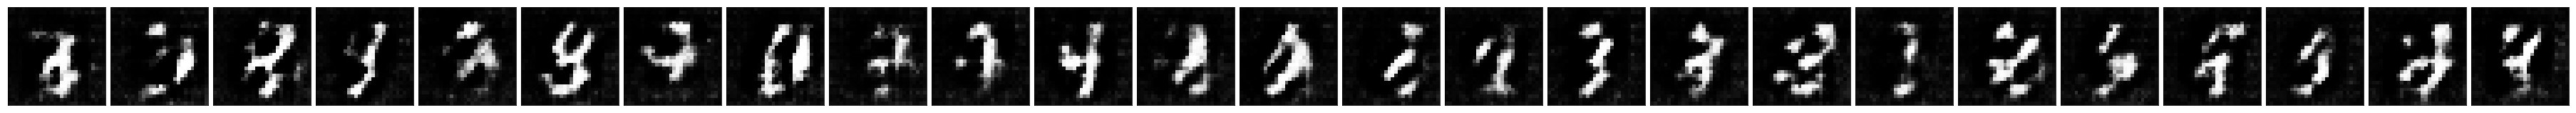

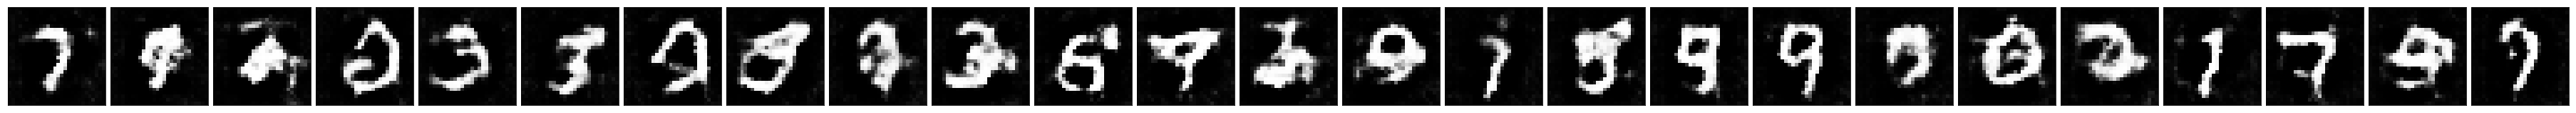

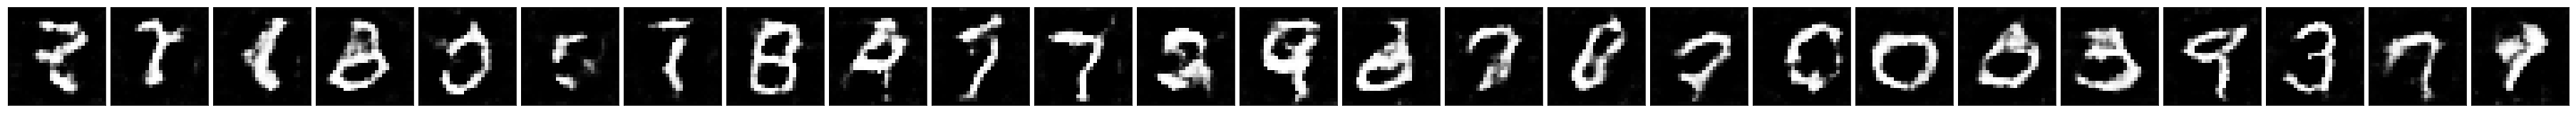

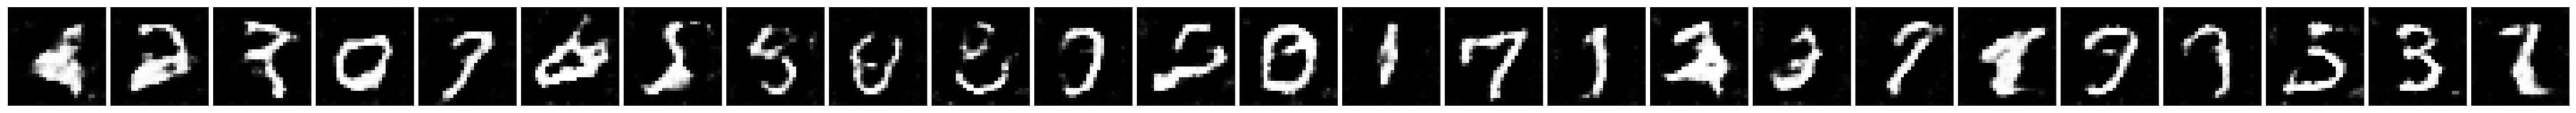

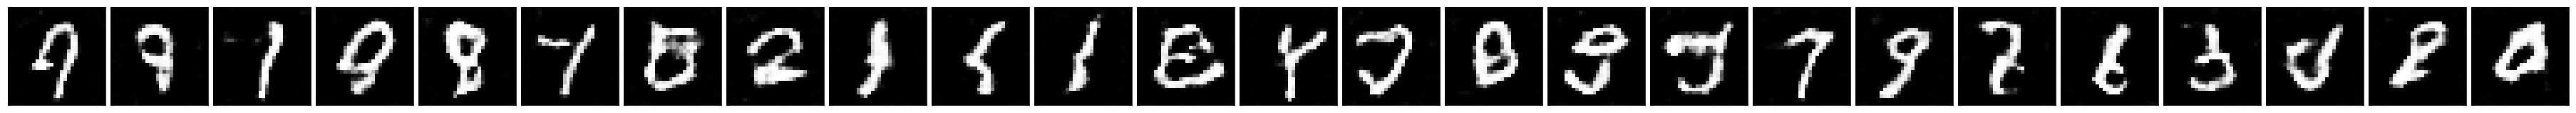

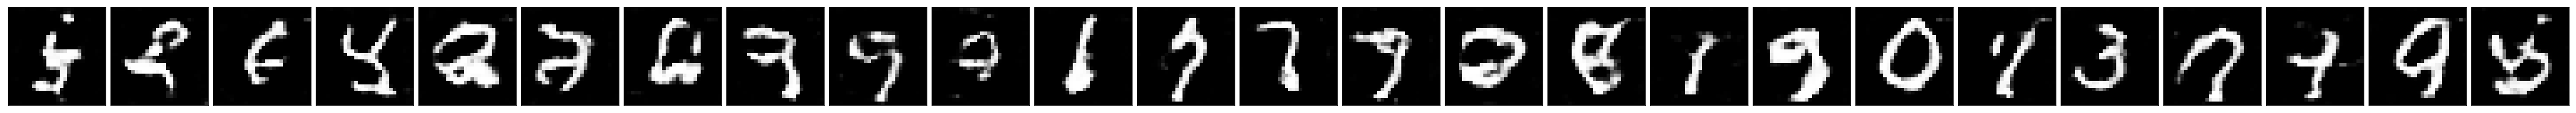

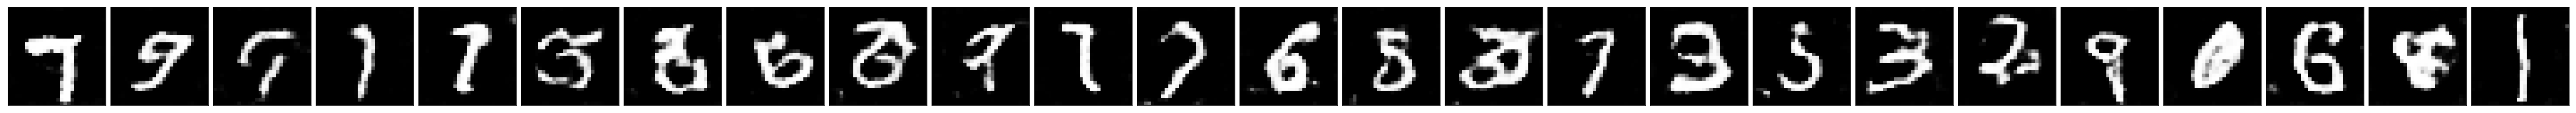

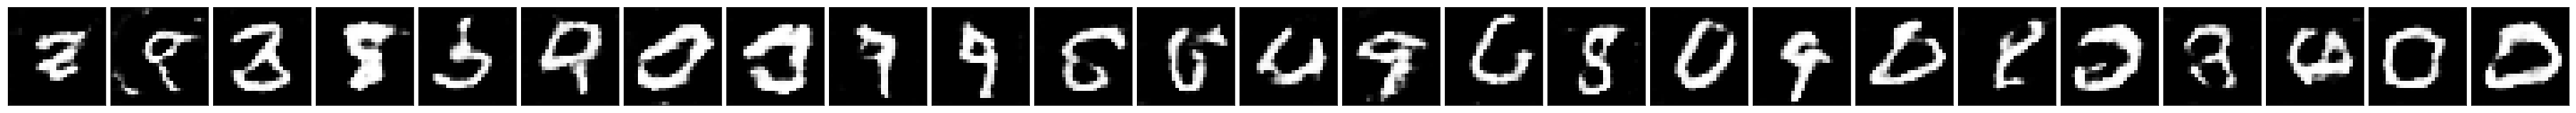

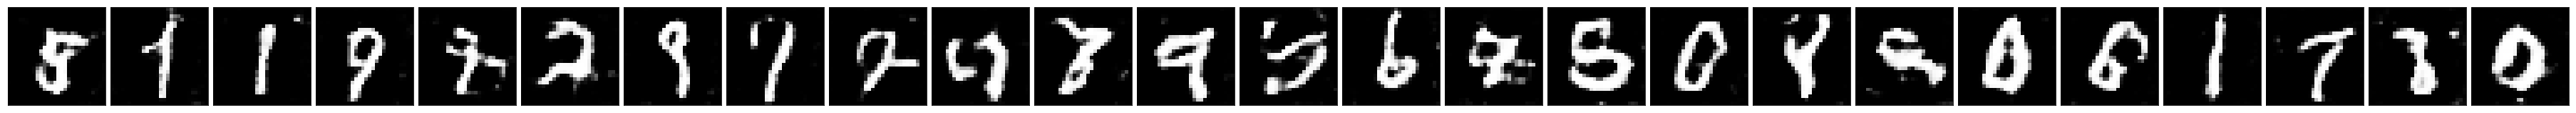

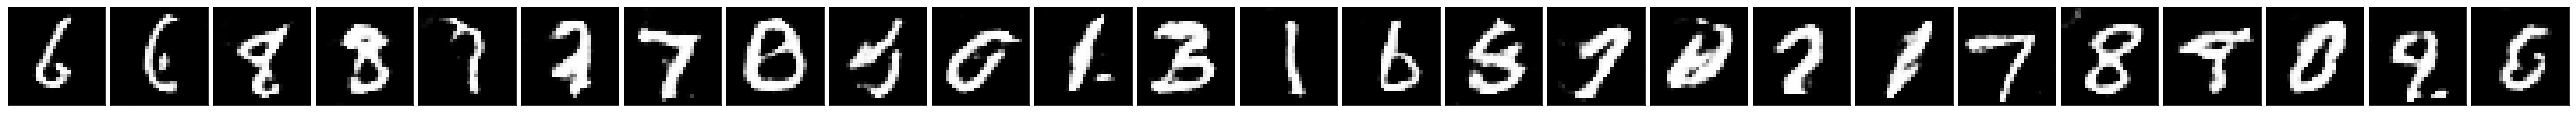

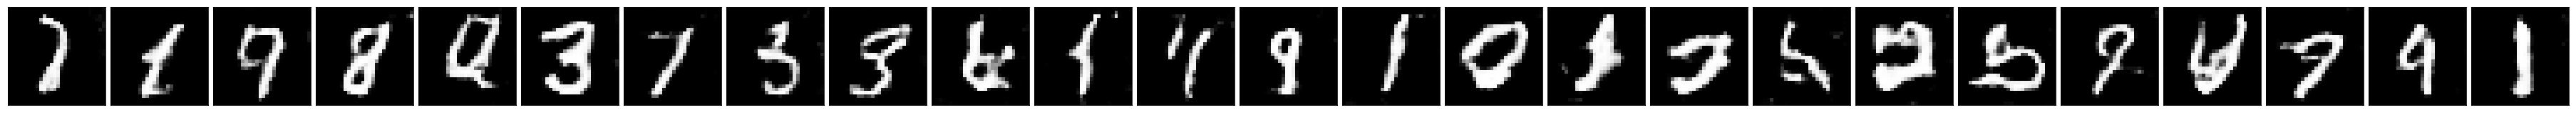

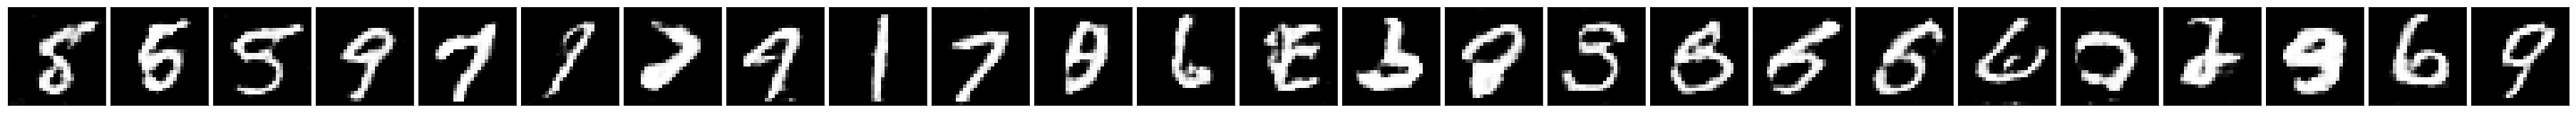

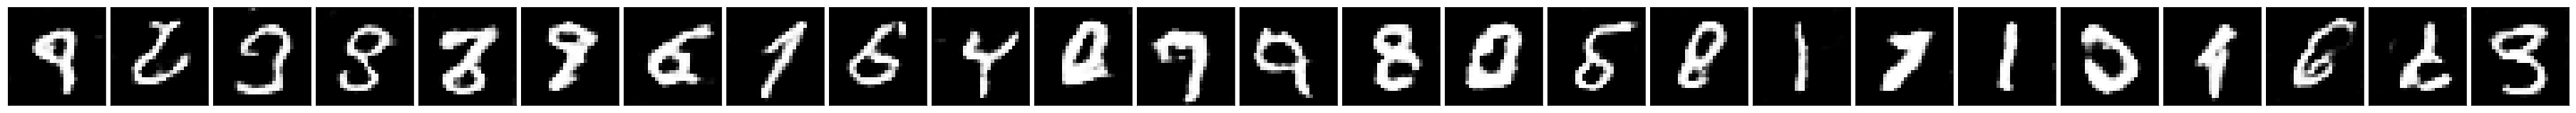

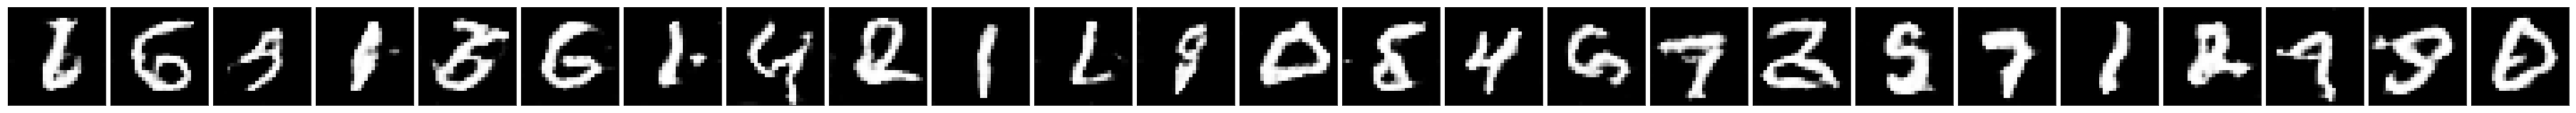

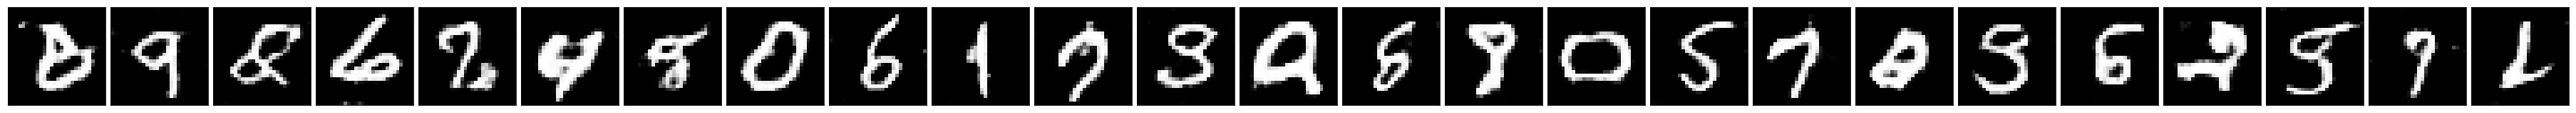

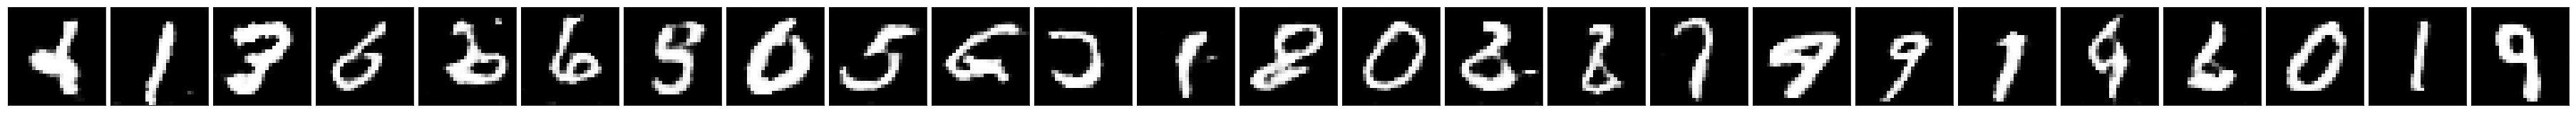

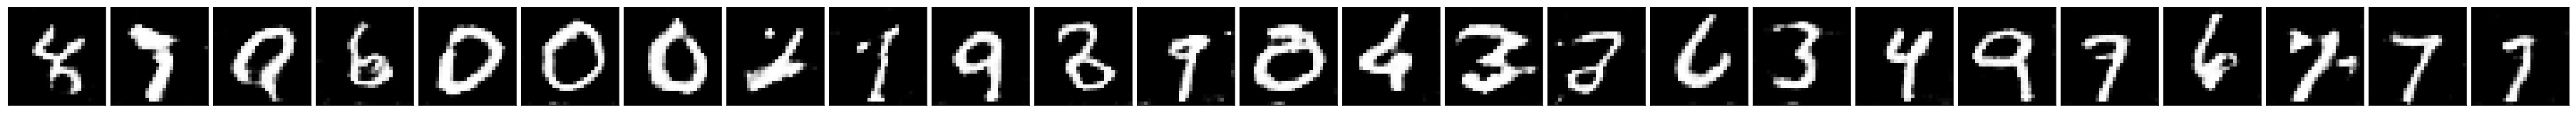

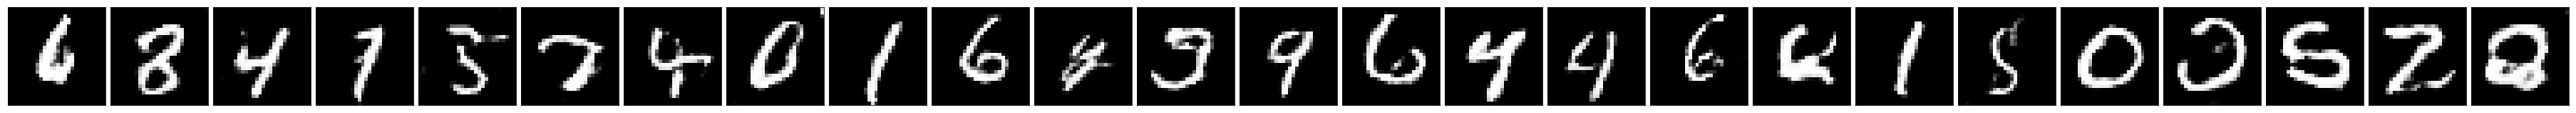

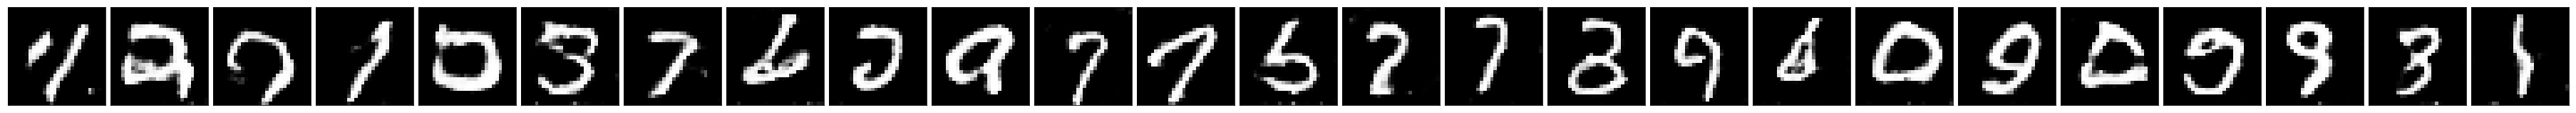

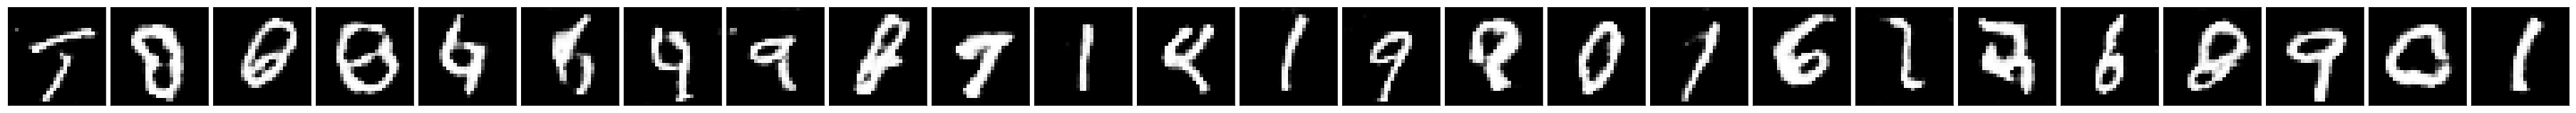

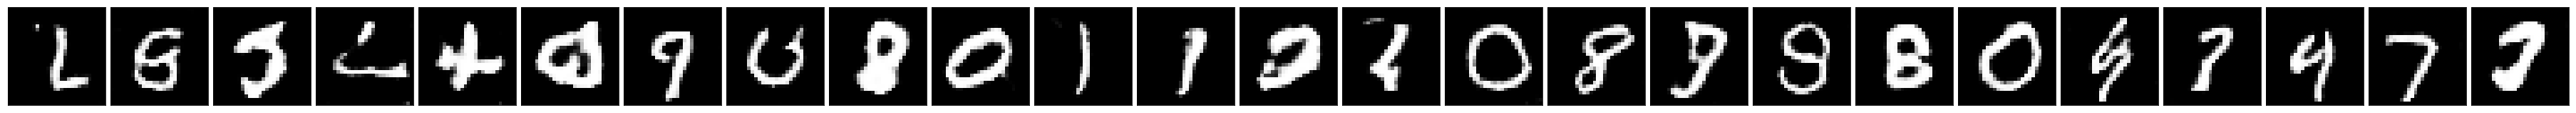

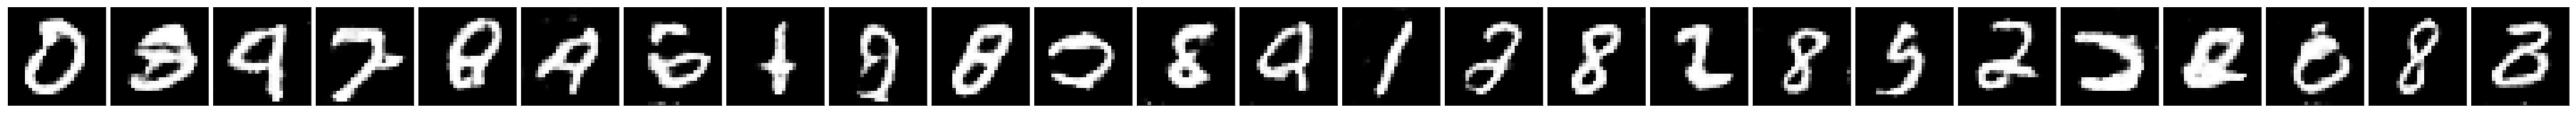

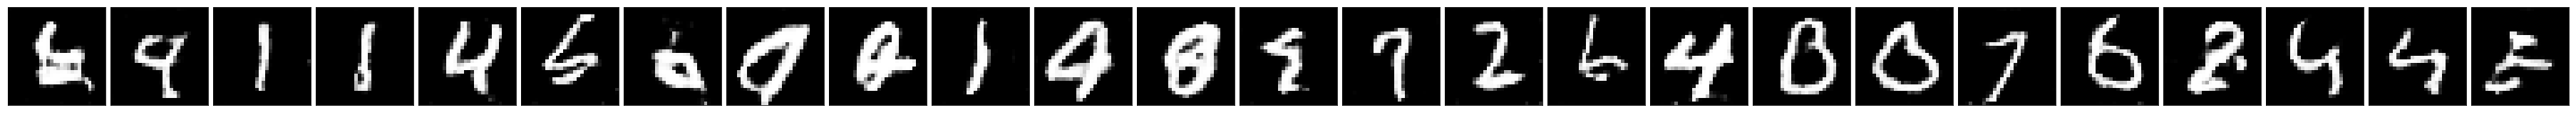

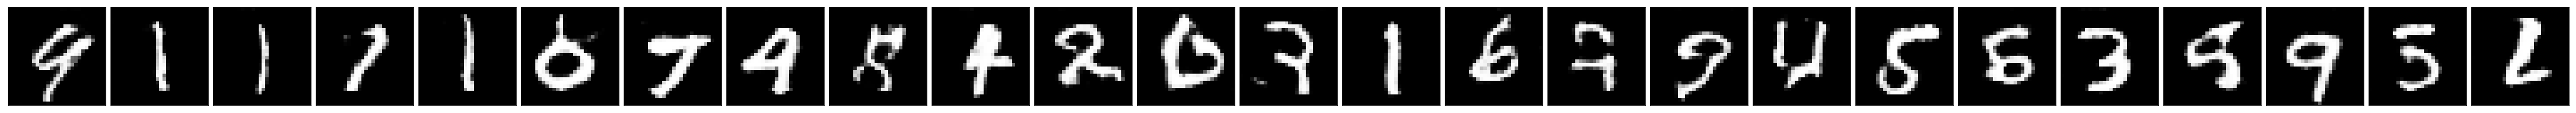

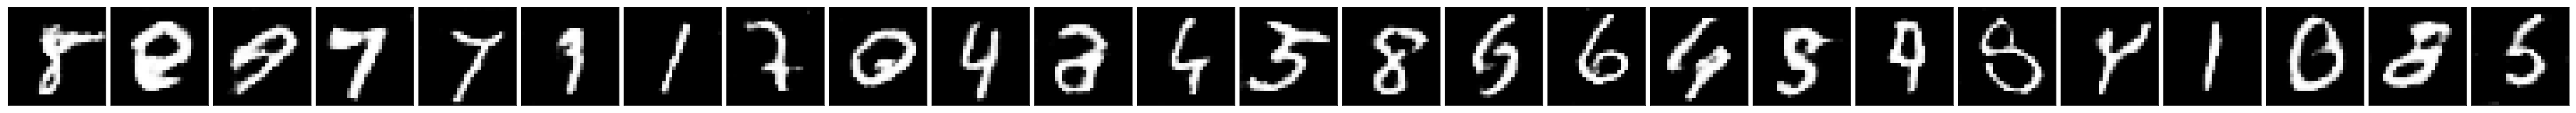

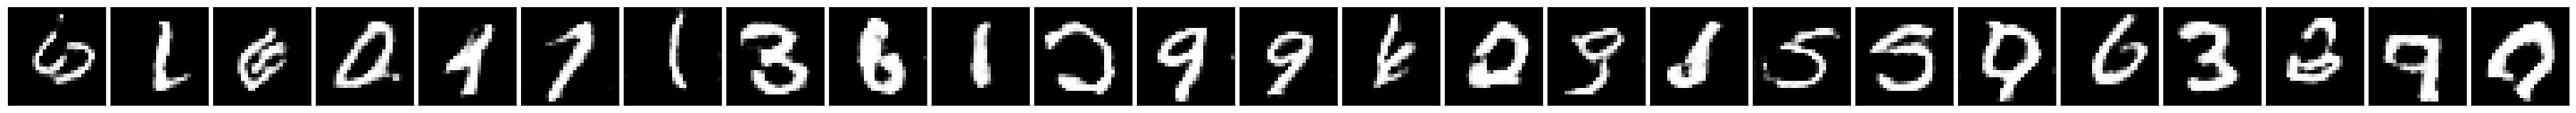

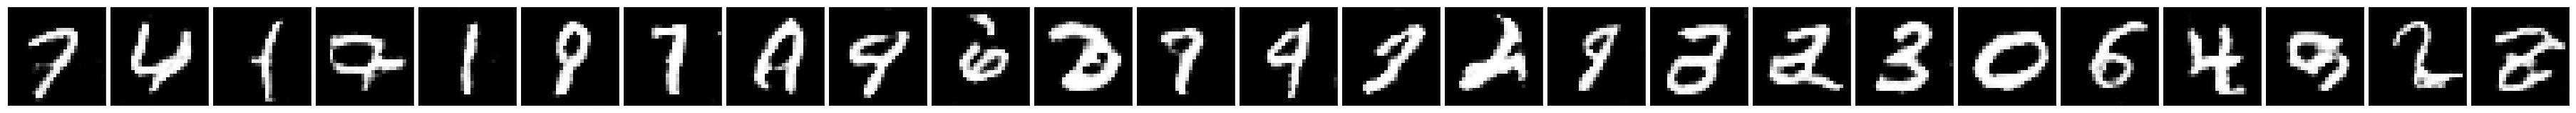

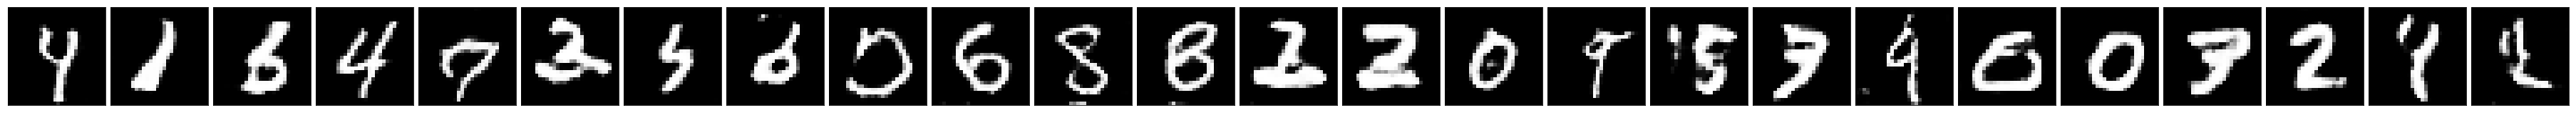

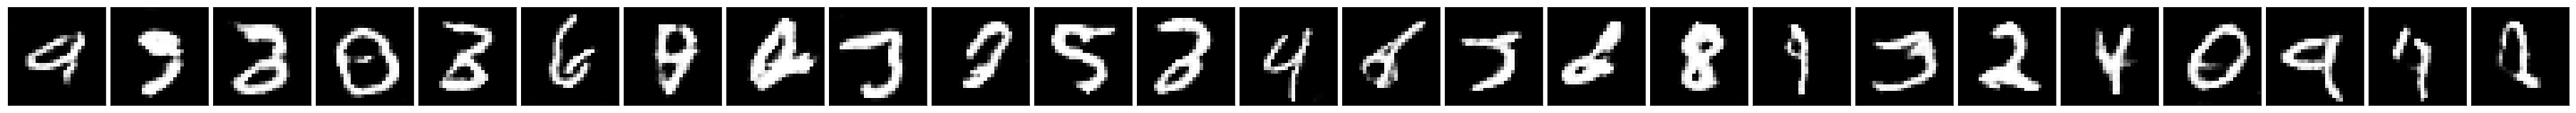

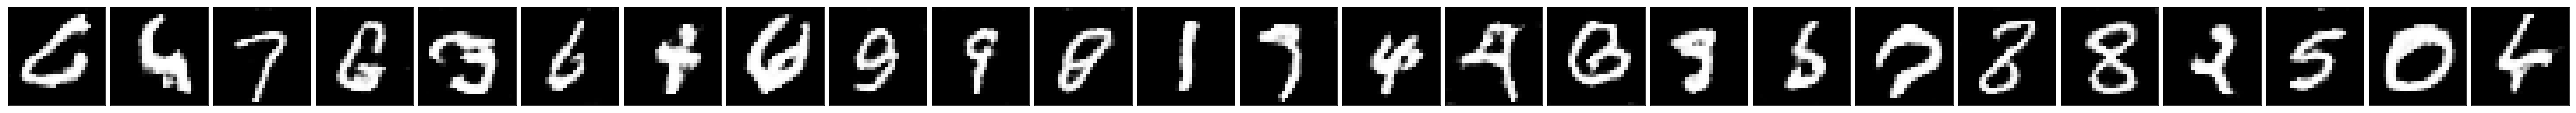

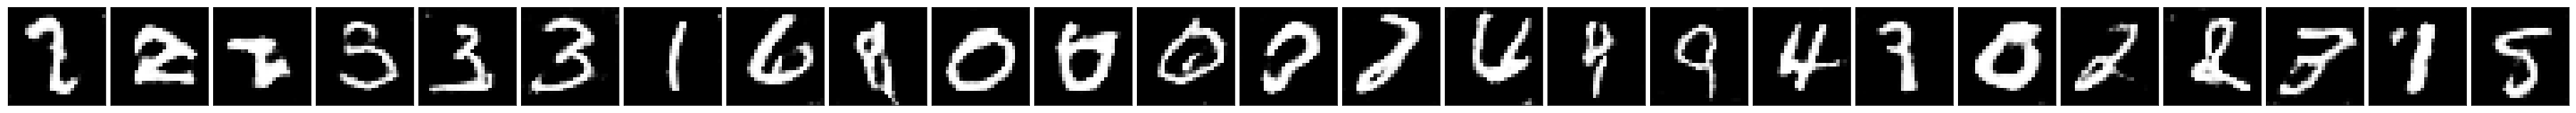

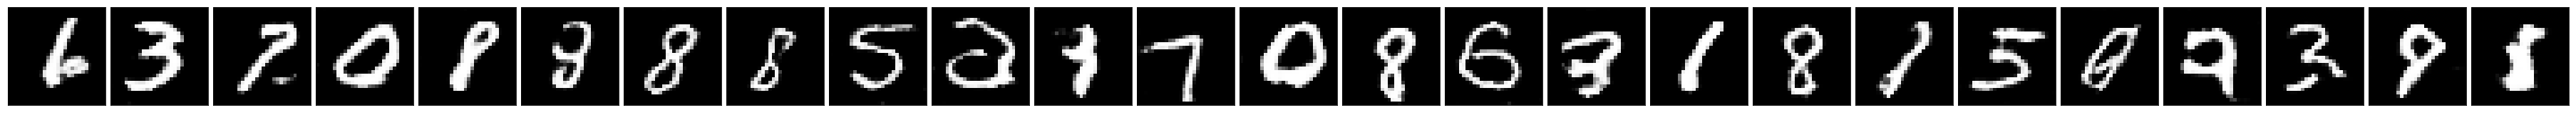

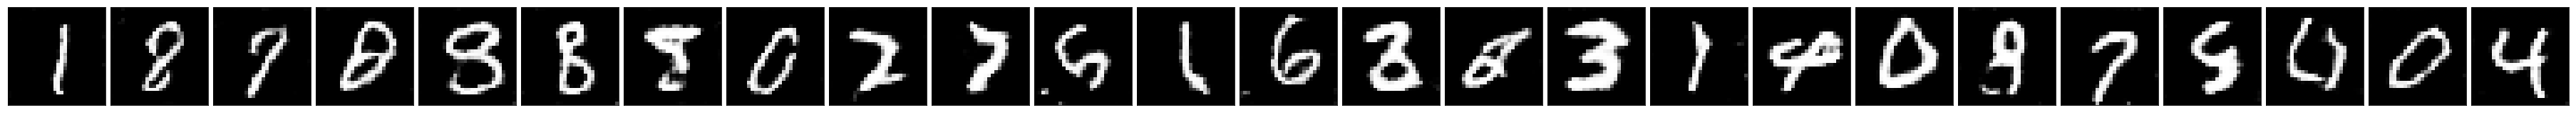

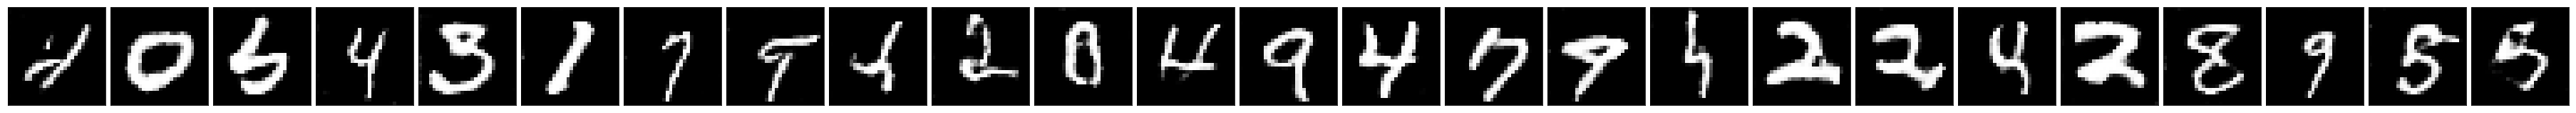

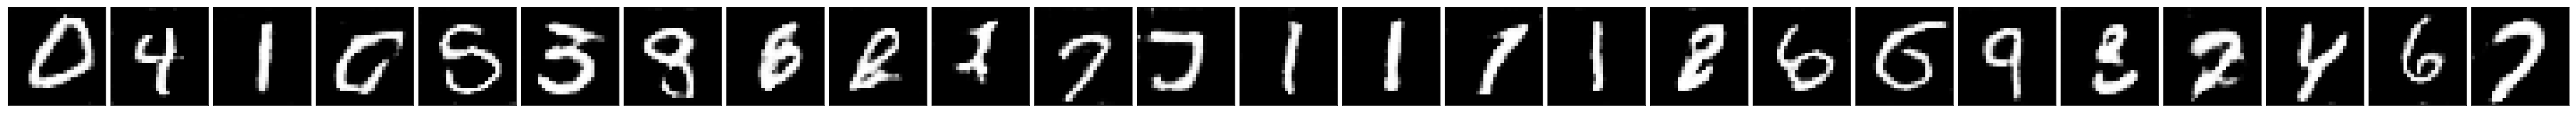

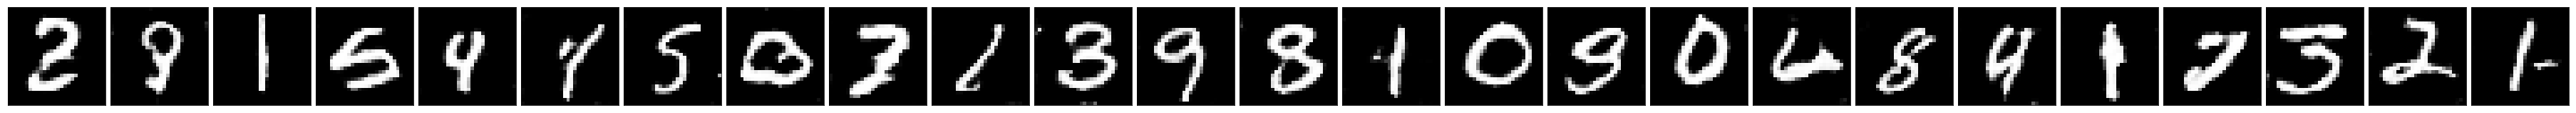

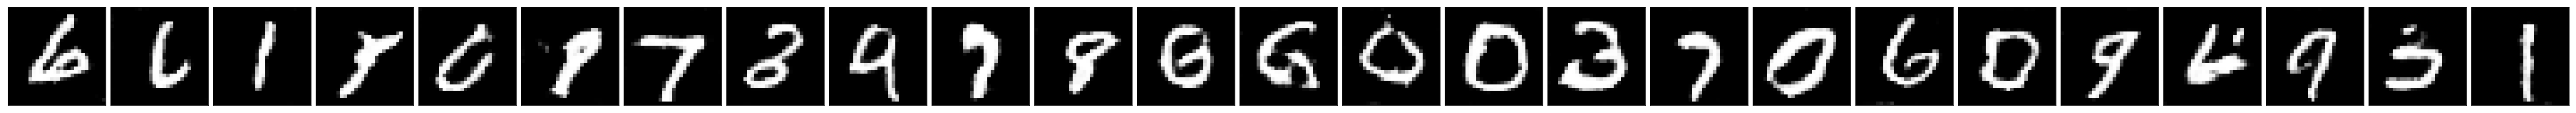

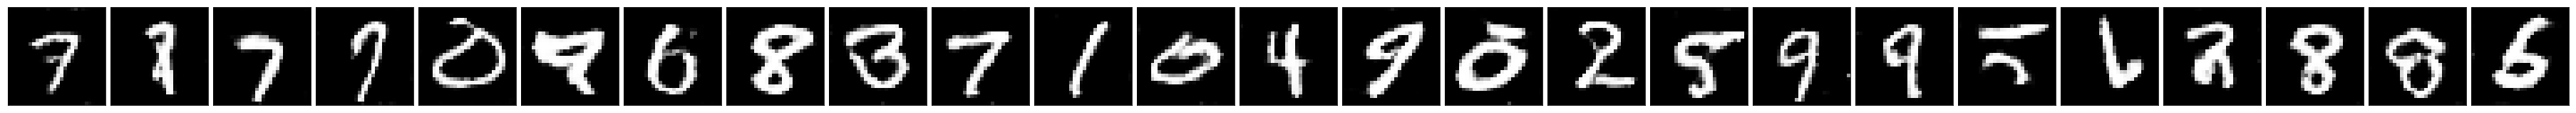

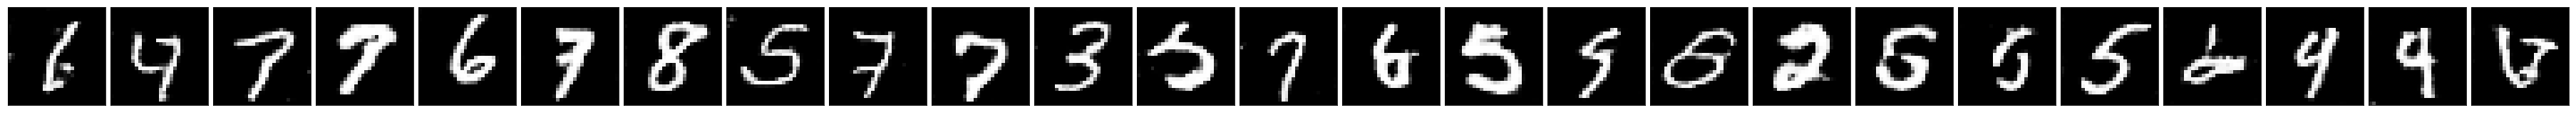

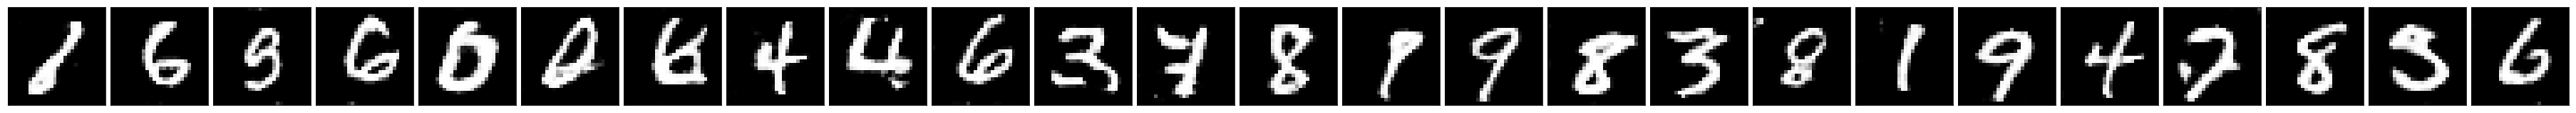

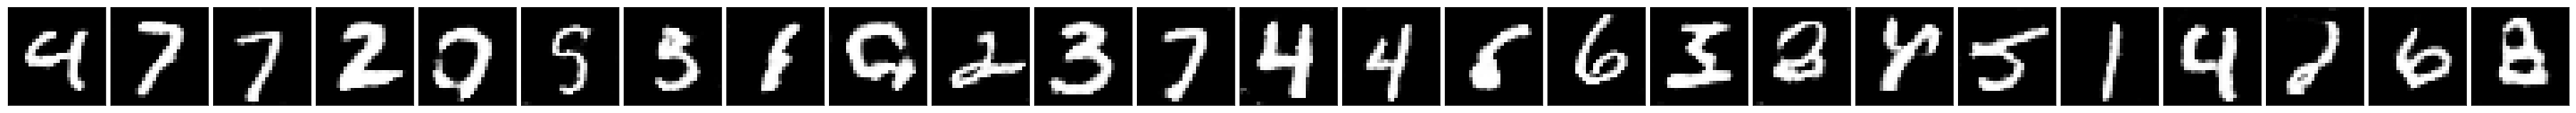

In [9]:
with tf.Graph().as_default():
    train(noise_size, [-1, 28, 28, 1], batch_size, n_samples)